# MAR6669 - Customer Churn Model and Logistic Regression

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_curve, roc_auc_score, accuracy_score, confusion_matrix, auc
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

### Using packages to preprocessing

In [2]:
model_df = pd.read_csv("/content/drive/MyDrive/MAR6669-data/Telco-Customer-Churn.csv")

In [3]:
model_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
model_df['TotalCharges'] = model_df['TotalCharges'].replace(' ', np.nan).astype(float)
model_df['TotalCharges'].astype('double')
model_df = model_df.dropna()

model_df.drop('customerID', axis=1, inplace=True)
model_df['Churn'] = model_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [5]:
# this next set of code sets up some important features of the dataset
# it also includes code that identifies features by type (categorical or numerical)

SEED = 365
TARGET = 'Churn'
FEATURES = model_df.columns.drop(TARGET)

NUMERICAL = model_df[FEATURES].select_dtypes('number').columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: SeniorCitizen, tenure, MonthlyCharges, TotalCharges
Categorical features: Contract, Dependents, DeviceProtection, InternetService, MultipleLines, OnlineBackup, OnlineSecurity, PaperlessBilling, Partner, PaymentMethod, PhoneService, StreamingMovies, StreamingTV, TechSupport, gender


In [6]:
# this section of code will set up the data for prediction correctly
# preprocessing

X = model_df.drop(columns=TARGET)
Y = model_df[TARGET]

num_imputer = SimpleImputer(strategy='mean')
num_imputed = num_imputer.fit_transform(X[NUMERICAL])

scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(num_imputed)

cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
cat_imputed = cat_imputer.fit_transform(X[CATEGORICAL])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
cat_encoded = encoder.fit_transform(cat_imputed)

preprocessed = np.concatenate((num_scaled,cat_encoded), axis=1)

columns = np.append(NUMERICAL, encoder.get_feature_names_out(CATEGORICAL))
preprocessed = pd.DataFrame(preprocessed, columns=columns, index=X.index)

In [7]:
# train test split
train_preprocessed, test_preprocessed, y_train, y_test = train_test_split(preprocessed, Y, test_size=0.2, random_state=SEED)

In [8]:
# Set up a logistic regression model type to train
model = LogisticRegression()
model.fit(train_preprocessed, y_train)

probs = model.predict_proba(test_preprocessed)[:,-1]
predictions = model.predict(test_preprocessed)


In [9]:
# This section sets up a metric (AUC) function  to use to assess the model and to compare between models.
def calculate_roc_auc(model, X, y):
    """Calculate roc auc score. 
    
    Parameters:
    ===========
    model_pipe: sklearn model or pipeline
    X: features
    y: true target
    """
    y_proba = model.predict_proba(X)[:,1]
    return roc_auc_score(y, y_proba)

In [10]:
print(f"Train ROC-AUC: {calculate_roc_auc(model, train_preprocessed, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(model, test_preprocessed, y_test):.4f}")

Train ROC-AUC: 0.8468
Test ROC-AUC: 0.8487


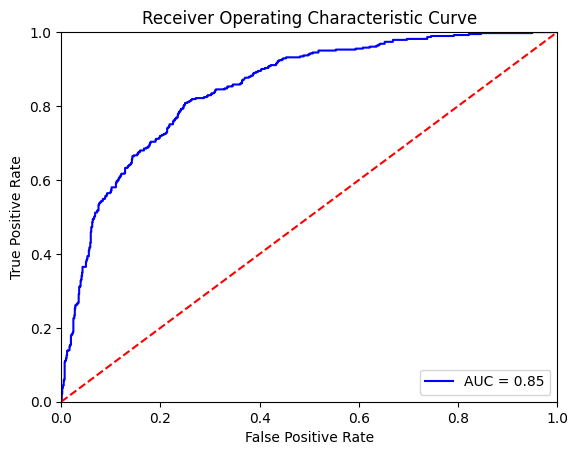

In [11]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
# create the confusion matrix for the model
# Actuals are on the horizontal... Predictions are on the vertical
confusion_matrix(y_test, predictions)

array([[932,  94],
       [167, 214]])

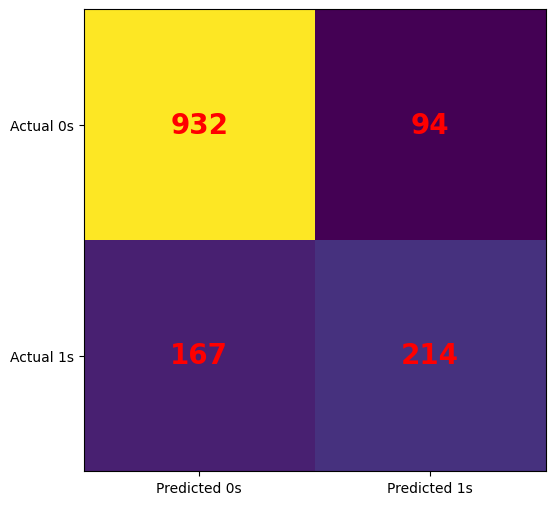

In [13]:
# illustrate the confusion matrix
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red', weight = 'bold', fontsize = 20)
plt.show()

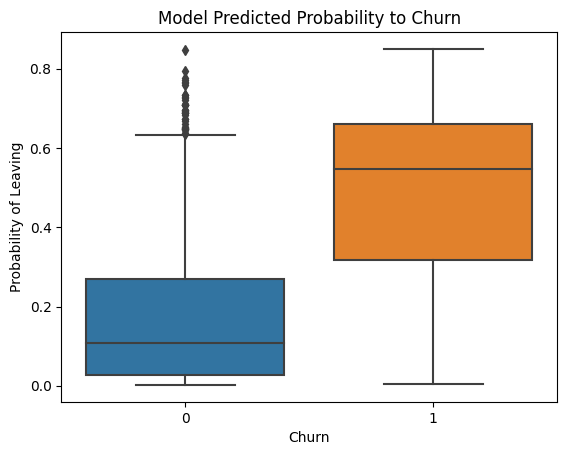

In [14]:
# Churn comparison
sns.boxplot (y=probs, x=y_test);
plt.xlabel("Churn")
plt.ylabel("Probability of Leaving")
plt.title("Model Predicted Probability to Churn")
plt.show()

In [15]:
# other key metrics
predictions_test = predictions
accuracy_test = accuracy_score(y_test, predictions_test)
predictions_train = model.predict(train_preprocessed)
accuracy_train = accuracy_score(y_train, predictions_train)
print("Train accuracy is = ", accuracy_train)
print("Test accuracy is = ", accuracy_test)

Train accuracy is =  0.8028444444444445
Test accuracy is =  0.814498933901919
